In [1]:
import scanpy as sc
import pandas as pd
import sys
from scipy.stats import pearsonr
from generate_gene_block import plot_gene_block

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 200)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
adata_de = sc.read_h5ad('../../../../3_expts/processed_data/CD4i_final//DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed='r')
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_clustering_additional_filtering.h5ad', backed='r')
de_by_guide = pd.read_csv('../3_DE_analysis/results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('../3_DE_analysis/results/DE_donor_robustness_correlation_summary.csv', index_col=0)
de_summary_stats = pd.read_csv('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [19]:
# # Define core TCR signaling genes
# core_tcr = ['CD3D', 'CD3E', 'CD3G', 'CD247', 'ZAP70', 'LAT', 'VAV1', 'LCP2', 'PLCG1']

# # Get all genes from TCR clusters, include genes that are in both Stim8hr and Stim48hr 
# set1 = set(adata_final[adata_final.obs.hdbscan==37].obs.target_contrast_gene_name_corrected.tolist())
# set2 = set(adata_final[adata_final.obs.hdbscan==109].obs.target_contrast_gene_name_corrected.tolist())
# set_stim8hr_stim48hr = set(adata_de[adata_de.obs.culture_condition=='Stim8hr'].obs.target_contrast_gene_name_corrected) &\
# set(adata_de[adata_de.obs.culture_condition=='Stim48hr'].obs.target_contrast_gene_name_corrected)
# gene_tcr = list((set1|set2)&set_stim8hr_stim48hr)

# sup = {'OTUD7B', 'SCRIB', 'GAD1', 'GRB2', 'NCK1', 'MAP4K1', 'CBLB', 'CD5', 'TRAF6',
#        'NFATC2', 'FYB1', 'GRAP2', 'IKBKG', 'CHUK', 'NFKBIA', 'NFKB2', 'NFKB1', 'RELA',
#        'PRKCB', 'PIK3R1', 'PIK3R2', 'PDPK1', 'DAG1', 'DGKZ', 'DGKA', 'TNFAIP3', 'CARD11'}
# gene_sup = list(sup&set_stim8hr_stim48hr)

# adata_tmp = adata_de[(adata_de.obs.culture_condition=='Stim8hr')&(adata_de.obs.target_contrast_gene_name_corrected.isin(gene_tcr+gene_sup))].to_memory().copy()
# df_stim8hr = pd.DataFrame(data=adata_tmp.layers['zscore'],
#                           index=adata_tmp.obs.target_contrast_gene_name_corrected.tolist(),
#                           columns=adata_tmp.var.gene_name.tolist())
# corr_stim8hr = df_stim8hr.T.corr()
# np.fill_diagonal(corr_stim8hr.values, np.nan)

# adata_tmp = adata_de[(adata_de.obs.culture_condition=='Stim48hr')&(adata_de.obs.target_contrast_gene_name_corrected.isin(gene_tcr+gene_sup))].to_memory().copy()
# df_stim48hr = pd.DataFrame(data=adata_tmp.layers['zscore'],
#                           index=adata_tmp.obs.target_contrast_gene_name_corrected.tolist(),
#                           columns=adata_tmp.var.gene_name.tolist())
# corr_stim48hr = df_stim48hr.T.corr()
# np.fill_diagonal(corr_stim48hr.values, np.nan)

In [154]:
# Define core TCR signaling genes
core_tcr = ['CD3D', 'CD3E', 'CD3G', 'CD247', 'ZAP70', 'LAT', 'VAV1', 'LCP2', 'PLCG1']

# Get all genes from TCR clusters, include genes that are in both Stim8hr and Stim48hr 
set1 = set(adata_final[adata_final.obs.hdbscan==37].obs.target_contrast_gene_name_corrected.tolist())
set2 = set(adata_final[adata_final.obs.hdbscan==109].obs.target_contrast_gene_name_corrected.tolist())
set_stim8hr_stim48hr = set(adata_de[adata_de.obs.culture_condition=='Stim8hr'].obs.target_contrast_gene_name_corrected) &\
set(adata_de[adata_de.obs.culture_condition=='Stim48hr'].obs.target_contrast_gene_name_corrected)
gene_tcr = list((set1|set2)&set_stim8hr_stim48hr)

sup = {'OTUD7B', 'SCRIB', 'GAD1', 'GRB2', 'NCK1', 'MAP4K1', 'CBLB', 'CD5', 'TRAF6', 'SOS1', 'PPP3CA', 'ITGAL', 'ITGB2',
       'NFATC2', 'FYB1', 'GRAP2', 'IKBKG', 'CHUK', 'NFKBIA', 'NFKB2', 'NFKB1', 'RELA', 'SYK', 'FYN', 'CD4', 'PTPN6',
       'PRKCB', 'PIK3R1', 'PIK3R2', 'PDPK1', 'DAG1', 'DGKZ', 'DGKA', 'TNFAIP3', 'CARD11', 'PIK3CA', 'PIK3CD', 'PIK3CG'}
gene_sup = list(sup&set_stim8hr_stim48hr)

In [155]:
# Calculate the correlation of significant DEs
adata_tmp = adata_de[(adata_de.obs.culture_condition=='Stim8hr')&(adata_de.obs.target_contrast_gene_name_corrected.isin(gene_tcr+gene_sup))].to_memory().copy()
corr_stim8hr = pd.DataFrame(data=None,
                          index=core_tcr,
                          columns=adata_tmp.obs.target_contrast_gene_name_corrected.tolist())
for i, gene1 in enumerate(corr_stim8hr.index):
    print(i)
    for gene2 in corr_stim8hr.columns:
        sig_downstream_mask = (adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene1].layers['adj_p_value']<0.1)|(adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene2].layers['adj_p_value']<0.1)
        on_target_mask = (adata_tmp.var.gene_name!=gene1)|(adata_tmp.var.gene_name!=gene2)
        mask = sig_downstream_mask & on_target_mask
        if np.sum(mask)>1:
            corr_stim8hr.loc[gene1, gene2] = pearsonr(adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene1, mask].layers['zscore'][0],
                                                     adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene2, mask].layers['zscore'][0]).statistic

np.fill_diagonal(corr_stim8hr.values, np.nan)

adata_tmp = adata_de[(adata_de.obs.culture_condition=='Stim48hr')&(adata_de.obs.target_contrast_gene_name_corrected.isin(gene_tcr+gene_sup))].to_memory().copy()
corr_stim48hr = pd.DataFrame(data=None,
                          index=core_tcr,
                          columns=adata_tmp.obs.target_contrast_gene_name_corrected.tolist())
for i, gene1 in enumerate(corr_stim48hr.index):
    print(i)
    for gene2 in corr_stim48hr.columns:
        sig_downstream_mask = (adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene1].layers['adj_p_value']<0.1)|(adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene2].layers['adj_p_value']<0.1)
        on_target_mask = (adata_tmp.var.gene_name!=gene1)|(adata_tmp.var.gene_name!=gene2)
        mask = sig_downstream_mask & on_target_mask
        if np.sum(mask)>1:
            corr_stim48hr.loc[gene1, gene2] = pearsonr(adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene1, mask].layers['zscore'][0],
                                                     adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene2, mask].layers['zscore'][0]).statistic

np.fill_diagonal(corr_stim48hr.values, np.nan)

0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


In [ ]:
for gene in gene_tcr:
    
    # Define the data for the two blocks (0.0 is minimum, 1.0 is maximum color intensity)
    # The order is: [Left_Block, Right_Block]
    sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 
    
    # Generate the plot
    plot_gene_block(gene, sample_measurements, colormap='vlag', vmin=-0.8, vmax=0.8, incluster=True, output_filename='./results/for_TCR_schematics/'+gene+'.png')

In [156]:
for gene in gene_sup:
    
    # Define the data for the two blocks (0.0 is minimum, 1.0 is maximum color intensity)
    # The order is: [Left_Block, Right_Block]
    sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 
    
    # Generate the plot
    plot_gene_block(gene, sample_measurements, colormap='vlag', vmin=-0.8, vmax=0.8, incluster=False, output_filename='./results/for_TCR_schematics/'+gene+'.png')

Figure successfully saved to ./results/for_TCR_schematics/NFKBIA.png
Figure successfully saved to ./results/for_TCR_schematics/PDPK1.png
Figure successfully saved to ./results/for_TCR_schematics/SYK.png
Figure successfully saved to ./results/for_TCR_schematics/DGKZ.png
Figure successfully saved to ./results/for_TCR_schematics/NFKB2.png
Figure successfully saved to ./results/for_TCR_schematics/ITGB2.png
Figure successfully saved to ./results/for_TCR_schematics/GAD1.png
Figure successfully saved to ./results/for_TCR_schematics/PIK3CD.png
Figure successfully saved to ./results/for_TCR_schematics/PPP3CA.png
Figure successfully saved to ./results/for_TCR_schematics/GRAP2.png
Figure successfully saved to ./results/for_TCR_schematics/PIK3R2.png
Figure successfully saved to ./results/for_TCR_schematics/GRB2.png
Figure successfully saved to ./results/for_TCR_schematics/TRAF6.png
Figure successfully saved to ./results/for_TCR_schematics/RELA.png
Figure successfully saved to ./results/for_TCR_sch

In [92]:
for gene in core_tcr:
    sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 
    
    # Generate the plot
    plot_gene_block(gene, sample_measurements, colormap='vlag', vmin=-0.9, vmax=0.9, incluster=True, output_filename='./results/for_TCR_schematics/'+gene+'.png')

Figure successfully saved to ./results/for_TCR_schematics/CD3D.png
Figure successfully saved to ./results/for_TCR_schematics/CD3E.png
Figure successfully saved to ./results/for_TCR_schematics/CD3G.png
Figure successfully saved to ./results/for_TCR_schematics/CD247.png
Figure successfully saved to ./results/for_TCR_schematics/ZAP70.png
Figure successfully saved to ./results/for_TCR_schematics/LAT.png
Figure successfully saved to ./results/for_TCR_schematics/VAV1.png
Figure successfully saved to ./results/for_TCR_schematics/LCP2.png
Figure successfully saved to ./results/for_TCR_schematics/PLCG1.png


In [6]:
gene_tcr[0]

'TBX22'

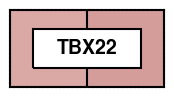

In [8]:
gene = gene_tcr[0]
    
# Define the data for the two blocks (0.0 is minimum, 1.0 is maximum color intensity)
# The order is: [Left_Block, Right_Block]
sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 

# Generate the plot
plot_gene_block(gene, sample_measurements, colormap='vlag', vmin=-0.9, vmax=0.9, incluster=True)#, output_filename='./results/for_TCR_schematics/'+gene+'.png')

In [152]:
de_summary_stats[de_summary_stats.target_name_corrected=='PTPN6']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
11105,ENSG00000111679,PTPN6,Stim8hr,344.0,0,2,2,-22.116832,True,305.890798,False,2-10 DE genes,on-target KD,ENSG00000111679,ENSG00000111679_Stim8hr,PTPN6
26396,ENSG00000111679,PTPN6,Stim48hr,369.0,2,2,4,-16.887258,True,206.924508,False,2-10 DE genes,on-target KD,ENSG00000111679,ENSG00000111679_Stim48hr,PTPN6
28299,ENSG00000111679,PTPN6,Rest,350.0,5,14,19,-13.492776,True,98.761511,False,>10 DE genes,on-target KD,ENSG00000111679,ENSG00000111679_Rest,PTPN6


In [172]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'NimbusSanL'

def plot_gene_block2(gene_name: str, measurements: np.ndarray, vmin=-0.8, vmax=0.8, colormap: str = 'Blues', incluster=True, output_filename: str = None):
    """
    Generates a 1x2 gene visualization block with a central gene name overlay.

    The color of each block (Left and Right) corresponds to the value in the 
    'measurements' array, mapped via the specified colormap.

    Args:
        gene_name (str): The name of the gene (e.g., 'MAP4K1').
        measurements (np.ndarray): A 1D NumPy array of two numerical values, 
                                   representing the measurement for each block.
                                   Structure: [Left_Block, Right_Block]
        colormap (str): The matplotlib colormap to use (e.g., 'Reds', 'viridis', etc.).
    """
    # 1. Setup the figure and axis
    # Adjusted figsize for a 1x2 horizontal look
    fig, ax = plt.subplots(figsize=(2, 1)) 
    
    # Reshape the 1D array (2 elements) into a 1x2 2D array for imshow.
    data_2d = measurements.reshape(1, 2)

    # 2. Plot the 1x2 data using imshow (creates the colored blocks)
    # extent=[xmin, xmax, ymin, ymax]. x runs from 0 to 2, y runs from 0 to 1.
    img = ax.imshow(data_2d, cmap=colormap, vmin=vmin, vmax=vmax, 
                    interpolation='nearest', extent=[0, 2, 0, 1]) 

    # 3. Apply plot aesthetics and add black line borders/separators
    ax.set_xticks([]) # Remove x ticks
    ax.set_yticks([]) # Remove y ticks

    if incluster:
        line_style = '-'
        line_width = 4
        font_weight = 'bold'
        custom_dashes = [2,0]
    else:
        line_style = '--'
        line_width = 4
        font_weight = 'normal'
        custom_dashes = [2,2]
    
    # Set all spines (outer borders) to be visible and black
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)
        spine.set_linestyle(line_style)
        spine.set_edgecolor('black')
        spine.set_visible(True) # Ensure all four borders are visible
        spine.set_linestyle((0, custom_dashes))
    
    # Add a black vertical line to separate the two blocks (at x=1.0)
    
    line = Line2D([1.0, 1.0], [0, 1], color='black', linewidth=line_width/2, zorder=1)
    line.set_linestyle((0, custom_dashes)) # Apply custom dashes
    ax.add_line(line)

    # Ensure the aspect ratio and limits are correct
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1) # Y-limit is now 1 for the 1x2 shape

    # 4. Draw the central white box (Rectangle patch)
    # The center of the 1x2 grid is now at (1.0, 0.5)
    box_width = 1.4
    box_height = 0.5
    center_x = 1.0
    center_y = 0.5
    
    # Create the white rectangle
    rect = patches.Rectangle(
        (center_x - box_width/2, center_y - box_height/2),  # (x, y) starting point (bottom-left)
        box_width, 
        box_height,
        linewidth=line_width/2,
        linestyle=line_style,
        edgecolor='black', # Border color
        facecolor='white', # Fill color
        zorder=2 # Ensure the box is above the colored blocks
    )
    rect.set_linestyle((0, custom_dashes)) 
    ax.add_patch(rect)

    # 5. Add the gene name text
    ax.text(
        center_x, center_y, # Position at the center of the plot (1.0, 0.5)
        gene_name,
        color='black',
        fontsize=18,
        fontweight=font_weight,
        ha='center', # Horizontal alignment: Center
        va='center', # Vertical alignment: Center
        zorder=3 # Ensure text is above the white box
    )

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # 6. Show the plot (or save it)
    if output_filename:
        # Save the figure with tight bounding box and high resolution (300 DPI)
        plt.savefig(output_filename,
                    bbox_inches='tight',
                    pad_inches=0,
                    dpi=300)
        plt.close(fig) # Close the figure to free memory
        print(f"Figure successfully saved to {output_filename}")
    else:
        plt.show()

In [173]:
gene = 'IKGKG'
#sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 
plot_gene_block2(gene, sample_measurements, colormap='Grays', vmin=-1, vmax=2, incluster=False, output_filename='./results/for_TCR_schematics/'+gene+'.png')

Figure successfully saved to ./results/for_TCR_schematics/IKGKG.png


In [193]:
de_summary_stats[de_summary_stats.target_name=='CALCOCO2']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
7710,ENSG00000136436,CALCOCO2,Rest,476.0,2,3,5,-17.490059,True,85.345005,False,2-10 DE genes,on-target KD,ENSG00000136436,ENSG00000136436_Rest,CALCOCO2
15260,ENSG00000136436,CALCOCO2,Stim8hr,488.0,1793,559,2352,-13.131464,True,50.366554,False,>10 DE genes,on-target KD,ENSG00000136436,ENSG00000136436_Stim8hr,CALCOCO2
29340,ENSG00000136436,CALCOCO2,Stim48hr,424.0,364,120,484,-16.948319,True,103.527459,False,>10 DE genes,on-target KD,ENSG00000136436,ENSG00000136436_Stim48hr,CALCOCO2


In [194]:
de_by_guide[de_by_guide.target=='CALCOCO2']

,target,correlation,correlation_ceiling,n_signif,culture_condition
1068,CALCOCO2,0.081757,NaN,3723,Stim8hr
2178,CALCOCO2,0.324911,0.436109,800,Stim48hr


In [195]:
donor_robustness_summary[donor_robustness_summary.target_name=='CALCOCO2']

,target_name,donor_correlation_mean,donor_correlation_min,target_contrast,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
116,CALCOCO2,0.587174,0.508740,ENSG00000136436,Stim8hr,488.0,1793,559,2352,-13.131464,True,50.366554,False,>10 DE genes,on-target KD
103,CALCOCO2,0.504574,0.410098,ENSG00000136436,Stim48hr,424.0,364,120,484,-16.948319,True,103.527459,False,>10 DE genes,on-target KD


In [180]:
len(set(de_by_guide[(de_by_guide.target.isin(gene_tcr))&(de_by_guide.correlation>0.2)].target))

137

In [187]:
print(set(de_by_guide[(de_by_guide.target.isin(gene_tcr))&(de_by_guide.correlation>0.2)].target) & set(donor_robustness_summary[(donor_robustness_summary.target_name.isin(gene_tcr))&(donor_robustness_summary.donor_correlation_min>0)].target_name))

{'CDIPT', 'ADAT3', 'ATRX', 'NUDCD1', 'ATP2A2', 'CLDN7', 'FOXM1', 'RPE', 'EIF4G2', 'PHF23', 'TMEM263', 'EWSR1', 'LRP5', 'COG6', 'ATXN7L3', 'CD247', 'SZRD1', 'CD2', 'COPS9', 'NR4A3', 'TNRC6A', 'PGAP2', 'ARPC2', 'GSS', 'SNAP23', 'SIK3', 'CALCOCO2', 'FBXW2', 'EML2', 'RBM33', 'PGGT1B', 'KAT2B', 'ELOB', 'MTX2', 'ZNF837', 'DDX60L', 'USP22', 'TEAD4', 'ABCC1', 'CYB5R4', 'MEN1', 'CD3G', 'TMEM205', 'L2HGDH', 'KCTD21', 'NCBP3', 'AASDH', 'SENP1', 'HELT', 'SND1', 'HTT', 'GNE', 'PPHLN1', 'CAMSAP1', 'WAS', 'NDFIP2', 'UBIAD1', 'ORAI1', 'GPD1L', 'NUP37', 'CREBBP', 'TPGS2', 'CD28', 'RAVER1', 'KNOP1', 'FMR1', 'CEP89', 'PLIN4', 'DCAF5', 'TLN1', 'RAC2', 'EIF1', 'RPS6KA1', 'RNF8', 'PRKRA', 'C1D', 'MALT1', 'GPI', 'CLCC1', 'DOLPP1', 'OST4', 'TXNDC9', 'NATD1', 'BLOC1S4', 'TBRG1', 'TBL1XR1', 'ARL6IP1', 'FBXW7', 'TBX22', 'BRWD1', 'SHOC2', 'SRR', 'DNAJC8', 'ITK', 'FOXO1', 'NABP1', 'PEX5', 'PLCG1', 'CAPZA1', 'KMT5B', 'KIF14', 'SOCS4', 'MDM4', 'KAT6A', 'BRAT1', 'TP73', 'NKAPD1', 'METTL23', 'PCNX3', 'ZC3H10', 'STAT5A

In [200]:
np.sort(['CDIPT', 'ADAT3', 'NUDCD1', 'TBC1D31', 'ATP2A2', 'FOXM1',
          'CLDN7', 'RPE', 'NCAPG2', 'EIF4G2', 'PHF23', 'IKBKB', 'TMEM263', 'NFIC',
          'EWSR1', 'LRP5', 'ATXN7L3', 'HAPSTR1', 'SAXO5', 'AKR1A1', 'SZRD1', 'ACO2',
          'MCFD2', 'PPP1R10', 'COPS9', 'KIF16B', 'NR4A3', 'TNRC6A', 'LRIG1', 'PGAP2', 
          'GSS','VEZT', 'HACD4', 'CNOT6L', 'ATF7IP2', 'SRSF11', 'SIK3', 'EML2', 'FBXW2', 
          'RBM33', 'ZNF790', 'DCAF6', 'CBLL1', 'PGGT1B', 'ELOB', 'MTX2', 'BCAT2', 
          'ZNF837', 'DDX60L', 'USP22', 'TEAD4', 'ABCC1', 'DCAF4', 'CYB5R4', 'OSR1', 
          'SACM1L', 'MEN1', 'ICE2', 'NUSAP1', 'TMEM205', 'TENT2', 'L2HGDH', 'KCTD21', 
          'APPL2', 'PLEK2', 'NCBP3', 'AASDH', 'SENP1', 'HELT', 'SND1', 'SPATA33', 'USP7', 
          'HTT', 'DCAF11', 'JADE2', 'GNE', 'CAMSAP1', 'RNF19B', 'PPHLN1', 'NDFIP2', 'CHURC1',
          'UBIAD1', 'GPD1L', 'NUP37', 'UBL7', 'C11orf54', 'ARID4B', 'TPGS2', 'KGD4',
          'RAVER1', 'KNOP1', 'TBP', 'ARHGAP27', 'CEP89', 'FMR1', 'SPON1', 'PLIN4', 'SYK',
          'CSH1', 'ZFYVE26', 'FAM204A', 'CUL4A', 'DCAF5', 'HEXD', 'IKZF1', 'TASOR', 'ABHD17A',
          'TXNDC12', 'EIF1', 'RPS6KA1', 'TM2D2', 'RNF8', 'PRKRA', 'SCAF4', 'MAP3K5', 'MALT1',
          'MTA3', 'ANKK1', 'MTRES1', 'VPS29', 'C1D', 'GPI', 'CLCC1', 'TMEM140', 'CRIPT', 'DOLPP1',
          'PYGM', 'SLC9A5', 'OST4', 'TXNDC9', 'NATD1', 'TTF1', 'BLOC1S4', 'TBRG1', 'PDCD5', 'TBL1XR1', 'ADRM1', 
          'FBXW7', 'TBX22', 'BRWD1', 'SHOC2', 'AIRIM', 'PARP3', 'DNAAF5', 'SRR', 'SLC7A6', 'TMED9', 'SLC3A2',
          'TPRG1L', 'FLVCR2', 'DNAJC8', 'NABP1', 'PEX5', 'CAPZA1', 'PGBD2', 'NCAPD3', 'ANKRD61', 'BICDL1',
          'ELMOD3', 'BRAT1', 'TP73', 'COQ10B', 'CHN2', 'NKAPD1', 'PPDPF', 'ZSCAN23', 'FCHO1', 'PIBF1',
          'NADK2', 'ZBED3', 'HSD17B12', 'NFIX', 'PHF19', 'PCNX3', 'ZC3H10', 'FITM2', 'COLGALT1', 'GALNT6',
          'RIDA', 'NUP188', 'PPP3R1', 'ENTPD1', 'TMX1', 'TXNL1', 'TTC7A', 'MAF', 'ANKRD49','DNAJC3', 'PPM1D',
          'RPS6KA3', 'DTX4', 'KPNA4', 'ZNF384', 'UBE2E2', 'XRRA1', 'ANAPC10', 'CCDC134'])

array(['AASDH', 'ABCC1', 'ABHD17A', 'ACO2', 'ADAT3', 'ADRM1', 'AIRIM',
       'AKR1A1', 'ANAPC10', 'ANKK1', 'ANKRD49', 'ANKRD61', 'APPL2',
       'ARHGAP27', 'ARID4B', 'ATF7IP2', 'ATP2A2', 'ATXN7L3', 'BCAT2',
       'BICDL1', 'BLOC1S4', 'BRAT1', 'BRWD1', 'C11orf54', 'C1D',
       'CAMSAP1', 'CAPZA1', 'CBLL1', 'CCDC134', 'CDIPT', 'CEP89', 'CHN2',
       'CHURC1', 'CLCC1', 'CLDN7', 'CNOT6L', 'COLGALT1', 'COPS9',
       'COQ10B', 'CRIPT', 'CSH1', 'CUL4A', 'CYB5R4', 'DCAF11', 'DCAF4',
       'DCAF5', 'DCAF6', 'DDX60L', 'DNAAF5', 'DNAJC3', 'DNAJC8', 'DOLPP1',
       'DTX4', 'EIF1', 'EIF4G2', 'ELMOD3', 'ELOB', 'EML2', 'ENTPD1',
       'EWSR1', 'FAM204A', 'FBXW2', 'FBXW7', 'FCHO1', 'FITM2', 'FLVCR2',
       'FMR1', 'FOXM1', 'GALNT6', 'GNE', 'GPD1L', 'GPI', 'GSS', 'HACD4',
       'HAPSTR1', 'HELT', 'HEXD', 'HSD17B12', 'HTT', 'ICE2', 'IKBKB',
       'IKZF1', 'JADE2', 'KCTD21', 'KGD4', 'KIF16B', 'KNOP1', 'KPNA4',
       'L2HGDH', 'LRIG1', 'LRP5', 'MAF', 'MALT1', 'MAP3K5', 'MCFD2',
       'MEN1',

In [33]:
corr_stim8hr

,NFKBIA,ADAT3,CDIPT,PDPK1
NFKBIA,NaN,-0.225284,0.129626,-0.094863
ADAT3,-0.225284,NaN,0.246407,-0.042858
CDIPT,0.129626,0.246407,NaN,-0.039339
PDPK1,-0.094863,-0.042858,-0.039339,NaN


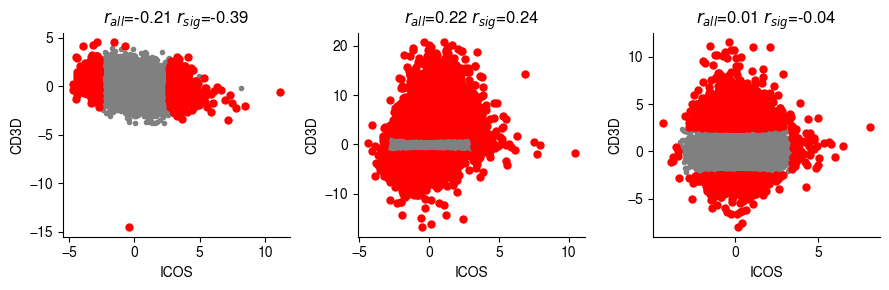

In [162]:
genelist =['ICOS', 'CD3D']
fig, ax = plt.subplots(1,3,figsize=(9,3))
for i, cond in enumerate(['Rest', 'Stim8hr', 'Stim48hr']):
    cond_mask = adata_de.obs['culture_condition']==cond
    target_gene_mask = ~adata_de.var['gene_name'].isin(genelist)
    gene1_zscore = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[0]),target_gene_mask].layers['zscore'][0].copy()
    gene1_padj = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[0]),target_gene_mask].layers['adj_p_value'][0].copy()
    gene2_zscore = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[1]),target_gene_mask].layers['zscore'][0].copy()
    gene2_padj = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[1]),target_gene_mask].layers['adj_p_value'][0].copy()
    sig_mask = (gene1_padj<0.1)|(gene2_padj<0.1)
    ax[i].plot(gene1_zscore[~sig_mask], gene2_zscore[~sig_mask], '.', color='gray')
    ax[i].plot(gene1_zscore[sig_mask], gene2_zscore[sig_mask], '.', color='red', markersize=10)
    ax[i].set_xlabel(genelist[0])
    ax[i].set_ylabel(genelist[1])
    result_all = pearsonr(gene1_zscore, gene2_zscore)
    result_sig = pearsonr(gene1_zscore[sig_mask], gene2_zscore[sig_mask])
    ax[i].set_title(r'$r_{all}$='+f'{result_all.statistic:.2f} '+r'$r_{sig}$='+f'{result_sig.statistic:.2f}')
sns.despine()
plt.tight_layout()

In [89]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='DGK1'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan,hdbscan_cluster_size,hdbscan_cluster_gene_size,hdbscan_corr_rest_over_corr_all,hdbscan_corr_stim8hr_over_corr_all,hdbscan_corr_stim48hr_over_corr_all


In [81]:
print(adata_final[adata_final.obs.hdbscan==37].obs['target_contrast_gene_name_corrected'].tolist())

['PLAT', 'LCK', 'PTPRC', 'SKIC2', 'TMX1', 'SLC3A2', 'UBE2E2', 'LRBA', 'HACD4', 'CALCOCO2', 'FITM2', 'PGGT1B', 'MTA3', 'ITK', 'APPL2', 'GPRASP1', 'NDFIP2', 'PLEK2', 'ARHGAP27', 'MBD5', 'EML2', 'RAC2', 'CAMSAP1', 'RAB19', 'DCAF11', 'TMEM205', 'SYK', 'TXNDC12', 'CRIPT', 'UBL7', 'CSH1', 'DCAF6', 'PPP3R1', 'WAS', 'PHF19', 'ABCC1', 'SHOC2', 'FLVCR2', 'BRWD1', 'KIF16B', 'SLC7A6', 'ZSCAN23', 'RAVER1', 'TASOR', 'ARID4B', 'JADE2', 'KCTD21', 'ANKRD61', 'MCFD2', 'HSD17B12', 'NFIX', 'TBC1D31', 'KAT6A', 'PGBD2', 'TLN1', 'SNAP29', 'DDX60L', 'TBX22', 'ARPC2', 'ADRM1', 'CDIPT', 'ABHD17A', 'NCBP3', 'ORAI2', 'TTC7A', 'PPP1R10', 'SPATA33', 'KPNA4', 'GPD1L', 'PEX5', 'TBP', 'DEF6', 'RBM33', 'LRIG1', 'TTF1', 'DTX4', 'AKR1A1', 'RNF19B', 'BLOC1S4', 'TMED9', 'TXNL1', 'NABP1', 'FBXW2', 'ATP2A2', 'MBD2', 'HEXD', 'CHURC1', 'SOS2', 'PLIN4', 'VPS35', 'UBIAD1', 'ANKK1', 'DNAJC8', 'ORAI1', 'COG6', 'ACO2', 'USP22', 'NUDCD1', 'ATXN7L3', 'PLCG1', 'CD247', 'LCP2', 'ZAP70', 'CD3G', 'VAV1', 'ZBED3', 'BCAT2', 'CD3D', 'CD3E',

In [ ]:
adata_final[adata_final.obs.hdbscan==109].obs.sort_values(by='target_contrast_gene_name_corrected')

In [ ]:
adata_final[adata_final.obs.hdbscan==37].obs.sort_values(by='target_contrast_gene_name_corrected')